In [1]:
!pip install GitPython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.5 MB/s eta 0:00:00


In [1]:
import os
import pandas as pd
import json
from tqdm import tqdm
import git
import sys
import re
import numpy as np

In [7]:
data_folder = os.path.join("dataset","result_refactoring")
REPOPATH = os.path.join("repo") # you need to populate repository here

## check whether commit involved changes to only test code

In [3]:
def getTest(files):
  res = []
  for f in files:
    if (".java" in f) and ((f.replace(".java","")[0:4].lower() == "test") or (f.replace(".java","")[-4:].lower() == "test")):
      res.append(f)
  return res

df = pd.read_csv("history.csv")

containsOnlyTest = []
for p,g in (df.groupby(by=["project"])):
  repo = git.Repo(os.path.join(REPOPATH,p))
  commits = ((set([i.split("::")[0] for i in g["description"]])))
  commits_object = [(repo.commit(commit),repo.commit(commit).parents[0]) for commit in commits]
  for cc,pc in tqdm(commits_object):
    diff = cc.diff(pc)
    # Extract the lists of modified, deleted, and added files
    modified_files = [item.a_path for item in diff.iter_change_type('M')]
    deleted_files = [item.a_path for item in diff.iter_change_type('D')]
    added_files = [item.b_path for item in diff.iter_change_type('A')]
    allfiles = modified_files+deleted_files+added_files

    test = getTest(modified_files) + getTest(deleted_files) +getTest(added_files)

    if len(set(allfiles).difference(set(test))) > 0:
      containsOnlyTest.append([p,cc,pc,False])
    else:
      containsOnlyTest.append([p,cc,pc,True])

In [ ]:
df2= pd.DataFrame(containsOnlyTest,columns=["project","parent_commit","commit","isTest"])
df2["commit"] = df2["commit"].astype(str)
df["commit"] = df["description"].str.split("::").str[0].astype(str)
df_Final = df.merge(df2[["project","commit","isTest"]],on="commit",how="left")

# Clone repository

In [ ]:
print(os.path.join("drive/MyDrive/Ph.D resources/Inheritance/Repository/",link))

drive/MyDrive/Ph.D resources/Inheritance/Repository/maven


In [ ]:
from git import Repo
from tqdm import tqdm

repolink = {
    "maven":"https://github.com/apache/maven.git",
    "cayenne":"https://github.com/apache/cayenne.git",
    "opennlp":"https://github.com/apache/opennlp.git",
    "iotdb":"https://github.com/apache/iotdb.git",
    "jclouds":"https://github.com/apache/jclouds.git",
    "commons-collections":"https://github.com/apache/commons-collections.git",
    "cucumber-jvm":"https://github.com/cucumber/cucumber-jvm.git",
    "httpcomponents-client":"https://github.com/apache/httpcomponents-client.git",
    "kylin":"https://github.com/apache/kylin.git",
    "cxf":"https://github.com/apache/cxf.git",
    "ratis":"https://github.com/apache/ratis.git",
    "pdfbox":"https://github.com/apache/pdfbox.git",
    "ranger":"https://github.com/apache/ranger.git",
    "wicket":"https://github.com/apache/wicket.git"
}
for link in tqdm(repolink):
  if link in ['cayenne',
 'maven',
 'opennlp',
 'iotdb',
 'jclouds',
 'commons-collections']:
    continue
  if not os.path.exists(os.path.join("drive/MyDrive/Ph.D resources/Inheritance/Repository/",link)):
    os.makedirs(os.path.join("drive/MyDrive/Ph.D resources/Inheritance/Repository/",link))
  Repo.clone_from(repolink[link], os.path.join("drive/MyDrive/Ph.D resources/Inheritance/Repository",link))

100%|██████████| 14/14 [05:24<00:00, 23.19s/it]


# [1] Get Refactoring History

#### load inheritance history dataset

In [8]:
def get_files():
  data_ = {}
  for project in os.listdir(data_folder):
    if project == "opennlp" or project == "pdfbox":
      continue
    data_[project] = json.load(open(os.path.join(data_folder,project,project+"_refactoring_history.json")))
  return data_
data_history = get_files()

#### extract inheritance and interface changes for test code and source code separately

In [9]:
result_history_test = []
result_history_src = []
for project in data_history:
  for k in (data_history[project]["commits"]):
    if len(k["refactorings"]) > 0:
      for rft in (k["refactorings"]):
        if "class extension" in (rft["description"].lower()):
          clazzleft = (rft["leftSideLocations"][0]["filePath"]).split("/")[-1].replace(".java","").lower()
          clazzleft_full = (rft["leftSideLocations"][0]["filePath"]).split("/")[-1].replace(".java","").lower()
          clazzright = (rft["rightSideLocations"][0]["filePath"]).split("/")[-1].replace(".java","").lower()
          clazzright_full = (rft["rightSideLocations"][0]["filePath"]).split("/")[-1].replace(".java","").lower()
          if (clazzleft[0:4] == "test" or clazzleft[-4:] == "test") or (clazzright[0:4] == "test" or clazzright[-4:] == "test"):
            result_history_test.append([project,rft["type"],clazzleft,clazzright,k["sha1"]+"::"+rft["description"].lower()])
          else:
            result_history_src.append([project,rft["type"],clazzleft,clazzright,k["sha1"]+"::"+rft["description"].lower()])

        if "class implementation" in (rft["description"].lower()):
          clazzleft = (rft["leftSideLocations"][0]["filePath"]).split("/")[-1].replace(".java","").lower()
          clazzleft_full = (rft["leftSideLocations"][0]["filePath"]).split("/")[-1].replace(".java","").lower()
          clazzright = (rft["rightSideLocations"][0]["filePath"]).split("/")[-1].replace(".java","").lower()
          clazzright_full = (rft["rightSideLocations"][0]["filePath"]).split("/")[-1].replace(".java","").lower()
          if (clazzleft[0:4] == "test" or clazzleft[-4:] == "test") or (clazzright[0:4] == "test" or clazzright[-4:] == "test"):
            result_history_test.append([project,rft["type"],clazzleft,clazzright,k["sha1"]+"::"+rft["description"].lower()])
          else:
            result_history_src.append([project,rft["type"],clazzleft,clazzright,k["sha1"]+"::"+rft["description"].lower()])

result_history_test = pd.DataFrame(result_history_test,columns=["project","rft","file_left","file_right","description"])
result_history_src = pd.DataFrame(result_history_src,columns=["project","rft","file_left","file_right","description"])

#### save data

In [10]:
result_history_test.to_csv("Test_Only_RFT.csv")
result_history_src.to_csv("Source_Only_RFT.csv")

#### summarizes total number of file that undergoes inheritance/interface change in test code and source code

In [11]:
print(result_history_test.groupby(by=["project","rft"]).apply(len).to_frame("Freq").reset_index()["Freq"].sum())
print(result_history_src.groupby(by=["project","rft"]).apply(len).to_frame("Freq").reset_index()["Freq"].sum())

4696
14096


# [2] Check if the inheritance and interface overlaps at the file level

#### Load inheritance refactoring history

In [12]:
def getTreeFiles():
  data_ = {}
  for project in os.listdir(data_folder):
    if project == "opennlp" or project == "pdfbox":
      continue
    data_[project] = json.load(open(os.path.join(data_folder,project,project+"_refactoring_tree.json")))
  return data_
data_tree = getTreeFiles()

In [13]:
def find_overlap(data_tree):
  projects = data_tree.keys()
  result = []
  for project in tqdm(projects):
    files = data_tree[project].keys()
    tree = data_tree[project]
    for f in files:
      df = (pd.DataFrame([tree[f][index].values() for index in (tree[f])],columns=["commit","file","rft"]))
      df = df.groupby(by=["commit","file"]).agg(list).reset_index()
      result.append(df)
  return pd.concat(result)
overlapping = find_overlap(data_tree)

100%|██████████| 12/12 [00:30<00:00,  2.58s/it]


#### Check if the file is a test or not

In [14]:
isTest = overlapping["rft"].apply(lambda x : set(x).intersection(set(result_history_test["description"])))
isProd = overlapping["rft"].apply(lambda x : set(x).intersection(set(result_history_src["description"])))
overlapping["isTest"] = isTest
overlapping["isProd"] = isProd

In [15]:
from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer

def checkType(x):
  import re
  se = re.search("(add|remove|replace).*(extension|implementation)",x.lower())
  return se.group(1)+ " class "+ se.group(2)




<ipython-input-15-abe479519262>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_test["Type"] = result_test["isTest"].apply(lambda x : [checkType(i) for i in x])
<ipython-input-15-abe479519262>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_source["Type"] = result_source["isProd"].apply(lambda x : [checkType(i) for i in x])


### This shows test/source file that has single level change pattern

In [ ]:
result_test = overlapping[overlapping["isTest"].str.len() > 0]
result_test["Type"] = result_test["isTest"].apply(lambda x : [checkType(i) for i in x])

result_source = overlapping[overlapping["isProd"].str.len() > 0]
result_source["Type"] = result_source["isProd"].apply(lambda x : [checkType(i) for i in x])

### This shows test/source file that has multi level change pattern

In [16]:
result_test_multi = result_test[result_test["Type"].str.len() > 1]
result_source_multi = result_source[result_source["Type"].str.len() > 1]

### Plots the change pattern

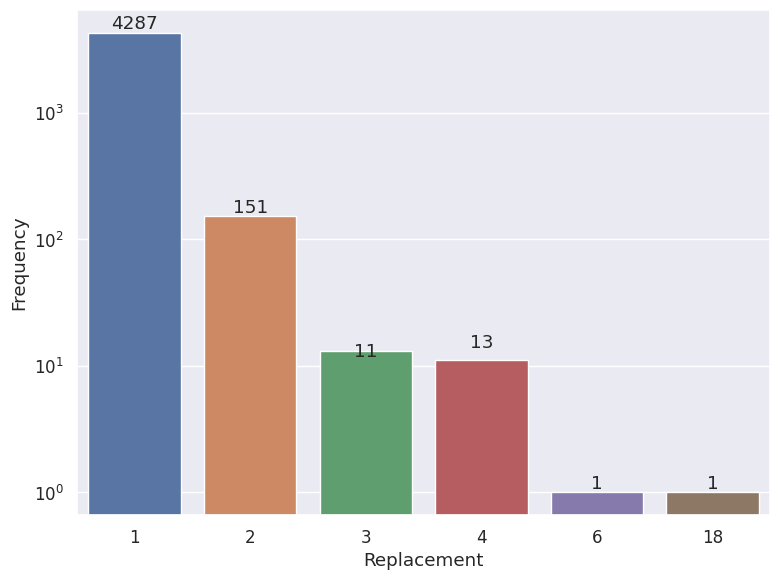

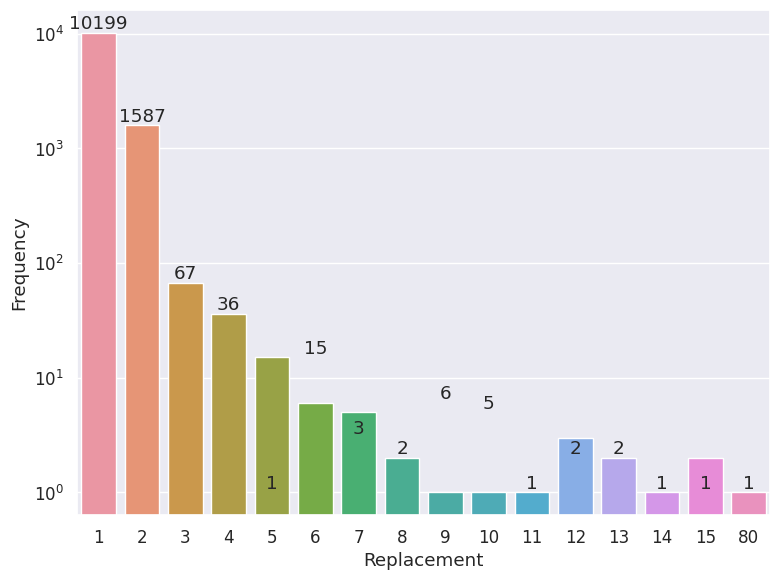

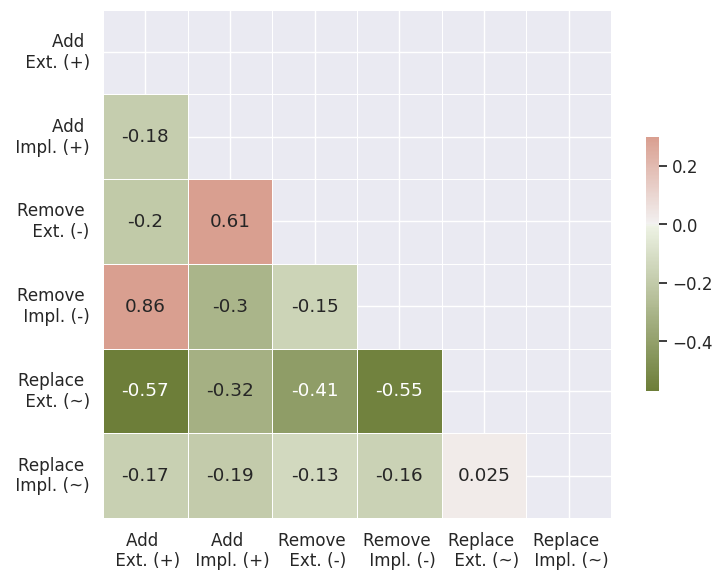

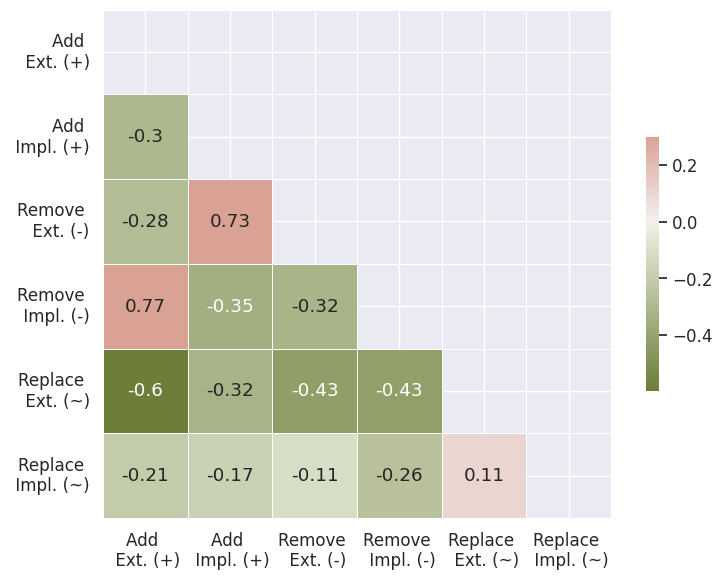

In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
from collections import Counter

plt.rcParams.update({'font.size': 20})

# Function to draw the barplot
def draw_Barplot(result_test,fname):
    # Create a figure for the barplot
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(8, 6))

    # Generate the barplot
    df2 = pd.DataFrame.from_dict(Counter(result_test["Type"].str.len()), orient='index').reset_index().rename(columns={"index": "Replacement", 0: "Frequency"}).sort_values(by=["Replacement"])
    g_Bar = sns.barplot(data=df2, x="Replacement", y="Frequency", ax=ax)

    for index, row in df2.iterrows():
        g_Bar.annotate(row['Frequency'], (index, row['Frequency']), ha='center', va='bottom')

    g_Bar.set_yscale("log")

    plt.tight_layout()

    # Save the barplot as a PDF file
    plt.savefig(fname)

# Function to draw the correlation heatmap
def draw_Corr(result_df,fname):
    # Create a figure for the heatmap
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(8, 6))

    # Call the draw_Corr function with your DataFrame
    mlb = MultiLabelBinarizer()
    df = pd.DataFrame(mlb.fit_transform(result_df["Type"]),columns=mlb.classes_, index=result_df.index)
    df = df.rename(columns={"add class extension":"Add \n Ext. (+)","remove class extension":"Remove \n Ext. (-)","replace class extension":"Replace \n Ext. (~)", \
                      "add class implementation":"Add \n Impl. (+)","remove class implementation":"Remove \n Impl. (-)","replace class implementation":"Replace \n Impl. (~)"
                      })
    # Compute the correlation matrix
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(100, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, ax=ax)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    plt.tight_layout()

    # Save the heatmap as a PDF file
    plt.savefig(fname)

# Your existing code for preparing the data
# ...

sns.set_theme()
sns.set(font_scale=1.1)  # You can adjust the font scale as needed
# Call the draw_Barplot function with your DataFrame for the barplot
draw_Barplot(result_test,"RQ2_Barplot_test.pdf")
draw_Barplot(result_source,"RQ2_Barplot_src.pdf")

# Call the draw_Corr function with your DataFrame for the heatmap
draw_Corr(result_test_multi,"RQ2_Heatmap_test.pdf")
draw_Corr(result_source_multi,"RQ2_Heatmap_src.pdf")


# RQ1-A

In [17]:
!pip install tree-sitter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.3/484.3 kB 6.6 MB/s eta 0:00:00


### Load tree-sitter necessary for parsing

In [18]:
import os
tree_sitter_dir = os.path.join("drive","MyDrive","tree-sitter")
build_tree = os.path.join(tree_sitter_dir,"build")
build_java = os.path.join(tree_sitter_dir,"tree-sitter-java")

from tree_sitter import Language, Parser
import sys
from tqdm import tqdm
import os
import json
import hashlib

Language.build_library(
  # Store the library in the `build` directory
  os.path.join(build_tree,'my-languages.so'),

  # Include one or more languages
  [
    build_java
  ]
)

JAVA_LANGUAGE = Language(os.path.join(build_tree,'my-languages.so'), 'java')
parser = Parser()
parser.set_language(JAVA_LANGUAGE)

In [ ]:
# Function to find "extends" or "implements" only in class declarations
def find_extends_implements_in_class_declarations(node):
    extends_implements_count = []

    if node.type == 'class_declaration':
        for child in node.children:
            if child.type == 'superclass' or child.type == 'super_interfaces':
                extends_implements_count.append(child.text.decode("utf-8"))

    for child in node.children:
        extends_implements_count += find_extends_implements_in_class_declarations(child)

    return extends_implements_count

In [ ]:
test_fname = {}
src_fname = {}
for p in data_tree:
  test_fname[p] = []
  src_fname[p] = []
  for fname in data_tree[p]:
    if fname.replace(".java","").split("::")[-1].split("/")[-1].lower()[0:4] == "test" or \
      fname.replace(".java","").split("::")[-1].split("/")[-1].lower()[-4:] == "test":
      test_fname[p].append(fname)
    else:
      src_fname[p].append(fname)



In [ ]:
def extract_inh_interface_at_beginning(data_tree,fnames):
  buff = []
  for p in (data_tree):
    print(p)
    reposit = git.Repo(os.path.join("drive/MyDrive/Ph.D resources/Inheritance/Repository",p))
    for fname in tqdm(fnames[p]):
      commits_ID = [[data_tree[p][fname][index]["commit"],
        reposit.commit(data_tree[p][fname][index]["commit"]),
        reposit.commit(data_tree[p][fname][index]["commit"]).committed_datetime
        ] for index in (data_tree[p][fname])]
      commits_ID =  sorted(commits_ID,key=lambda x: (x[2]))
      first_commit,commitObj,commit_Date = (commits_ID[0])
      parent_commitObj = commitObj.parents[0]
      commits_Group = [data_tree[p][fname][index] for index in data_tree[p][fname] if data_tree[p][fname][index]["commit"] == first_commit]
      file_parent = ""
      file_child   = ""
      rfts = ""
      if len([i for i in commits_Group if (("rename" in i["refactoring"]) or ("move" in i["refactoring"]))]) > 0:
        renamed_commit = [i for i in commits_Group if (("rename" in i["refactoring"]) or ("move" in i["refactoring"]))]
        file_parent = (renamed_commit[0]["left ==> right"].split(" ==> ")[0])
        file_child = (renamed_commit[0]["left ==> right"].split(" ==> ")[1])
        rfts = (renamed_commit[0]["refactoring"])
      else:
        file_parent = (commits_Group[0]["left ==> right"].split(" ==> ")[0])
        file_child = (commits_Group[0]["left ==> right"].split(" ==> ")[1])
        rfts = (commits_Group[0]["refactoring"])

      try:
        # Start
        file_content_start  = parent_commitObj.tree[file_parent].data_stream.read()
        tree_start = parser.parse(file_content_start)
        lst_start = find_extends_implements_in_class_declarations(tree_start.root_node)
        buff.append([p,str(parent_commitObj),first_commit,file_parent,file_child,[data_tree[p][fname][index]["refactoring"] for index in data_tree[p][fname]],fname,lst_start])
      except Exception as e:
        print(e)
        print(p)
        print(parent_commitObj)
        print(commitObj)
        print(file_parent)
        buff.append([p,str(parent_commitObj),first_commit,file_parent,file_child,[data_tree[p][fname][index]["refactoring"] for index in data_tree[p][fname]],fname,"ERROR"])
  buff = pd.DataFrame(buff,columns=["project","parent_commit","child_commit","parent_file","child_file","rft","key","modifiers_start"])
  return buff


RQ1_src = extract_inh_interface_at_beginning(data_tree,src_fname)
RQ1_test = extract_inh_interface_at_beginning(data_tree,test_fname)



In [ ]:
def checkType(x):
  import re
  se = re.search("(add|remove|replace).*(extension|implementation)",x.lower())
  if se:
    return se.group(1)+ " class "+ se.group(2)
  else:
    return False

RQ1_src["rft_abstract"] = RQ1_src["rft"].apply(lambda x : [checkType(i) for i in x if checkType(i)])
RQ1_test["rft_abstract"] = RQ1_test["rft"].apply(lambda x : [checkType(i) for i in x if checkType(i)])


In [ ]:
RQ1_src["rft_impl"] = RQ1_src["rft_abstract"].apply(lambda x : [i for i in x if "implementation" in i])
RQ1_src["rft_ext"] = RQ1_src["rft_abstract"].apply(lambda x : [i for i in x if "extension" in i])

RQ1_test["rft_impl"] = RQ1_test["rft_abstract"].apply(lambda x : [i for i in x if "implementation" in i])
RQ1_test["rft_ext"] = RQ1_test["rft_abstract"].apply(lambda x : [i for i in x if "extension" in i])

RQ1_test["extends"] = RQ1_test["modifiers_start"].apply(lambda x : [i for i in x if "extends" in i])
RQ1_test["extends"] = RQ1_test["extends"].apply(lambda x : [i for i in x if not re.search("extends.* (assert|testcase|org.junit.assert)",i.lower())])
RQ1_test["implements"] = RQ1_test["modifiers_start"].apply(lambda x : [i for i in x if "implements" in i])

RQ1_src["extends"] = RQ1_src["modifiers_start"].apply(lambda x : [i for i in x if "extends" in i])
RQ1_src["implements"] = RQ1_src["modifiers_start"].apply(lambda x : [i for i in x if "implements" in i])

In [ ]:
def printDistribution(RQ1):
  print("Has both inheritance and interface " , RQ1[(RQ1["extends"].str.len() > 0) & (RQ1["implements"].str.len() > 0)].shape[0])
  print("Has only inheritance " ,RQ1[(RQ1["extends"].str.len() > 0) & (RQ1["implements"].str.len() == 0)].shape[0])
  print("Has only interface " ,RQ1[(RQ1["extends"].str.len() == 0) & (RQ1["implements"].str.len() > 0)].shape[0])


  print()
  print("Has NONE " ,RQ1[(RQ1["extends"].str.len() == 0) & (RQ1["implements"].str.len()== 0)].shape[0])
  print("TOTAL == ",RQ1.shape[0])

printDistribution(RQ1_test)
print("--------")
printDistribution(RQ1_src)

Has both inheritance and interface  142
Has only inheritance  1615
Has only interface  89

Has NONE  1197
TOTAL ==  3043
--------
Has both inheritance and interface  964
Has only inheritance  2985
Has only interface  1720

Has NONE  1052
TOTAL ==  6721


# RQ1-B [HISTORY OF INHERITANCE AND INTERFACE CHANGE]

In [10]:
def getTreeFiles():
  data_ = {}
  for project in os.listdir(data_folder):
    if project == "opennlp" or project == "pdfbox":
      continue
    data_[project] = json.load(open(os.path.join(data_folder,project,project+"_refactoring_tree.json")))
  return data_
data_tree = getTreeFiles()

In [11]:
test_fname = {}
src_fname = {}
for p in data_tree:
  test_fname[p] = []
  src_fname[p] = []
  for fname in data_tree[p]:
    if fname.replace(".java","").split("::")[-1].split("/")[-1].lower()[0:4] == "test" or \
      fname.replace(".java","").split("::")[-1].split("/")[-1].lower()[-4:] == "test":
      test_fname[p].append(fname)
    else:
      src_fname[p].append(fname)



In [12]:
def checkType(x):
  import re
  se = re.search("(add|remove|replace).*(extension|implementation)",x.lower())
  if se:
    return se.group(1)+ " class "+ se.group(2)
  else:
    return False

In [35]:
import git
def RQ2(data_tree,filenames):
  res = []
  for project in data_tree:
    reposit = git.Repo(os.path.join("Inheritance_ISSTA\\repo",project))
    for fname in filenames[project]:
      evolution_Ext = []
      evolution_Impl = []
      evolution_date = []
      evolution_raw = []
      for row in data_tree[project][fname]:
        rft = checkType(data_tree[project][fname][row]["refactoring"])
        if rft:
          if "extension" in  rft.lower():
            evolution_Ext.append(data_tree[project][fname][row]["commit"])
          elif "implementation" in  rft.lower():
            evolution_Impl.append(data_tree[project][fname][row]["commit"])
        evolution_raw.append(data_tree[project][fname][row]["commit"])

      evolution_raw = list(set(evolution_raw))
      evolution_Ext = list(set(evolution_Ext))
      evolution_time_Ext = [reposit.commit(commit).authored_datetime for commit in evolution_Ext]

      evolution_Impl = list(set(evolution_Impl))
      evolution_time_Impl = [reposit.commit(commit).authored_datetime for commit in evolution_Impl]

      res.append([project,fname,evolution_Ext, evolution_time_Ext,evolution_Impl,evolution_time_Impl,evolution_raw])
  return pd.DataFrame(res,columns=["project","filename","evolution_Ext","evolution_time_Ext","evolution_Impl","evolution_time_Impl","evolution_raw"])

rq2_Df_test = RQ2(data_tree,test_fname)
rq2_Df_src = RQ2(data_tree,src_fname)
rq2_Df_test["Change Frequency Ext"] = rq2_Df_test["evolution_time_Ext"].str.len()
rq2_Df_test["Change Frequency Raw"] = rq2_Df_test["evolution_raw"].str.len()
rq2_Df_test["Change Frequency Impl"] = rq2_Df_test["evolution_time_Impl"].str.len()

rq2_Df_src["Change Frequency Ext"] = rq2_Df_src["evolution_time_Ext"].str.len()
rq2_Df_src["Change Frequency Raw"] = rq2_Df_src["evolution_raw"].str.len()
rq2_Df_src["Change Frequency Impl"] = rq2_Df_src["evolution_time_Impl"].str.len()


In [36]:
def precessing_ext():
  import numpy as np
  rq2_length_agg_test = rq2_Df_test["Change Frequency Ext"].value_counts().to_frame("Frequency").reset_index().rename(columns={"index":"Change Frequency Ext"}).sort_values(by=["Change Frequency Ext"])
  rq2_length_agg_src = rq2_Df_src["Change Frequency Ext"].value_counts().to_frame("Frequency").reset_index().rename(columns={"index":"Change Frequency Ext"}).sort_values(by=["Change Frequency Ext"])
  merged = pd.merge(rq2_length_agg_test,rq2_length_agg_src,on=["Change Frequency Ext"],how="outer")
  rq2_length_agg_test = merged[["Change Frequency Ext","Frequency_x"]].rename(columns={"Frequency_x":"Frequency"})
  rq2_length_agg_src = merged[["Change Frequency Ext","Frequency_y"]].rename(columns={"Frequency_y":"Frequency"})

  rq2_length_agg_test["Type"] = "Test"
  rq2_length_agg_src["Type"] = "Source"
  merged_final = pd.concat([rq2_length_agg_test,rq2_length_agg_src])
  merged_final = merged_final.fillna(0)
  return merged_final

def precessing_impl():
  import numpy as np
  rq2_length_agg_test = rq2_Df_test["Change Frequency Impl"].value_counts().to_frame("Frequency").reset_index().rename(columns={"index":"Change Frequency Impl"}).sort_values(by=["Change Frequency Impl"])
  rq2_length_agg_src = rq2_Df_src["Change Frequency Impl"].value_counts().to_frame("Frequency").reset_index().rename(columns={"index":"Change Frequency Impl"}).sort_values(by=["Change Frequency Impl"])
  merged = pd.merge(rq2_length_agg_test,rq2_length_agg_src,on=["Change Frequency Impl"],how="outer")
  rq2_length_agg_test = merged[["Change Frequency Impl","Frequency_x"]].rename(columns={"Frequency_x":"Frequency"})
  rq2_length_agg_src = merged[["Change Frequency Impl","Frequency_y"]].rename(columns={"Frequency_y":"Frequency"})

  rq2_length_agg_test["Type"] = "Test"
  rq2_length_agg_src["Type"] = "Source"
  merged_final = pd.concat([rq2_length_agg_test,rq2_length_agg_src])
  merged_final = merged_final.fillna(0)
  return merged_final

merged_ext = precessing_ext()
merged_impl = precessing_impl()

# merged_impl = merged_impl[merged_impl["Change Frequency Impl"] != 0].reset_index(drop=True)
# merged_ext = merged_ext[merged_ext["Change Frequency Ext"] != 0].reset_index(drop=True)


In [37]:
merged_ext[merged_ext['Type'] == "Test"]["Frequency"].sum()
merged_ext[merged_ext['Type'] == "Source"]["Frequency"].sum()


5814.0

In [38]:
merged_ext["Frequency"] = merged_ext["Frequency"].astype(int)
merged_impl["Frequency"] = merged_impl["Frequency"].astype(int)

In [39]:
merged_impl[merged_impl["Type"] == "Test"]["Frequency"]

0     2606
1      114
2       14
3        7
4        6
5        2
6        1
7        1
8        1
9        0
10       0
11       0
12       0
13       0
14       0
15       0
16       0
17       0
18       0
Name: Frequency, dtype: int32

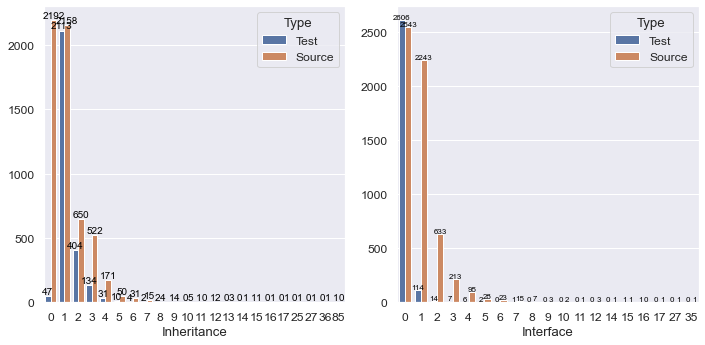

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
sns.set(font_scale=1.1)  # You can adjust the font scale as needed

# Create a single figure and axes for the subplot
fig, axes = plt.subplots(1,2, figsize=(10, 5))

# Create a bar plot for the first dataset
sns.barplot(
    data=merged_ext,
    x="Change Frequency Ext",
    y="Frequency",
    hue="Type",
    ax=axes[0]  # Use the first subplot
)
ax1 = axes[0]
ax1.set_ylabel("")
ax1.set_xlabel("Inheritance")  # Remove x-axis label for the first plot

# Add data labels to the bars of the first plot
for p in ax1.patches:
    height = p.get_height()
    ax1.annotate(f'{height:.0f}', (p.get_x() + p.get_width() / 2., height),
                 ha='center', va='bottom', fontsize=10, color='black')

# Create a bar plot for the second dataset
sns.barplot(
    data=merged_impl,
    x="Change Frequency Impl",
    y="Frequency",
    hue="Type",
    ax=axes[1]  # Use the second subplot
)
ax2 = axes[1]
ax2.set_ylabel("")
ax2.set_xlabel("Interface")  # Remove x-axis label for the first plot

# Add data labels to the bars of the second plot
for p in ax2.patches:
    height = p.get_height()
    ax2.annotate(f'{height:.0f}', (p.get_x() + p.get_width() / 2., height),
                 ha='center', va='bottom', fontsize=8, color='black')

# Remove extra space between subplots



fig.tight_layout()
# Save the figure
plt.savefig("RQ2_Change_Frequency_Subplot.pdf", format="pdf")

# Display the plot
plt.show()


# RQ1-B [HOW LONG IN DAYS IT TAKES TO CHANGE INHERITANCE AND INTERFACE]

In [57]:
import numpy as np
rq2_Df_test["evolution_time_Ext"] = rq2_Df_test["evolution_time_Ext"].apply(sorted)
rq2_Df_src["evolution_time_Ext"] = rq2_Df_src["evolution_time_Ext"].apply(sorted)
rq2_Df_test["evolution_time_Impl"] = rq2_Df_test["evolution_time_Impl"].apply(sorted)
rq2_Df_src["evolution_time_Impl"] = rq2_Df_src["evolution_time_Impl"].apply(sorted)


rq2_Df_test_diff_ext = rq2_Df_test[rq2_Df_test["evolution_time_Ext"].str.len() > 1].reset_index(drop=True)
rq2_Df_test_diff_impl= rq2_Df_test[rq2_Df_test["evolution_time_Impl"].str.len() > 1].reset_index(drop=True)
rq2_Df_src_diff_ext = rq2_Df_src[rq2_Df_src["evolution_time_Ext"].str.len() > 1].reset_index(drop=True)
rq2_Df_src_diff_impl= rq2_Df_src[rq2_Df_src["evolution_time_Impl"].str.len() > 1].reset_index(drop=True)

rq2_Df_test_diff_ext["Diff"] = rq2_Df_test_diff_ext["evolution_time_Ext"].apply(lambda x : [i.days for i in np.array(x)[1:]-np.array(x)[0:-1]])
rq2_Df_test_diff_impl["Diff"] = rq2_Df_test_diff_impl["evolution_time_Impl"].apply(lambda x : [i.days for i in np.array(x)[1:]-np.array(x)[0:-1]])
rq2_Df_src_diff_ext["Diff"] = rq2_Df_src_diff_ext["evolution_time_Ext"].apply(lambda x : [i.days for i in np.array(x)[1:]-np.array(x)[0:-1]])
rq2_Df_src_diff_impl["Diff"] = rq2_Df_src_diff_impl["evolution_time_Impl"].apply(lambda x : [i.days for i in np.array(x)[1:]-np.array(x)[0:-1]])


In [62]:
rq2_Df_test_diff_ext["Diff_time"] = (rq2_Df_test_diff_ext["Diff"]).apply(lambda x: list(range(0,len(x))))
# df = (rq2_Df_test_diff_ext.explode(["Diff","Diff_time"])[["Diff","Diff_time"]])


In [63]:
rq2_distribution_merging_test = rq2_Df_test_diff_ext.explode("Diff")[["Diff"]]
rq2_distribution_merging_test["Type"] = "Test"
rq2_distribution_merging_src = rq2_Df_src_diff_ext.explode("Diff")[["Diff"]]
rq2_distribution_merging_src["Type"] = "Source"

rq2_distribution_merging_ext = pd.concat([rq2_distribution_merging_test,rq2_distribution_merging_src])

rq2_distribution_merging_test = rq2_Df_test_diff_impl.explode("Diff")[["Diff"]]
rq2_distribution_merging_test["Type"] = "Test"
rq2_distribution_merging_src = rq2_Df_src_diff_impl.explode("Diff")[["Diff"]]
rq2_distribution_merging_src["Type"] = "Source"

rq2_distribution_merging_impl = pd.concat([rq2_distribution_merging_test,rq2_distribution_merging_src])


In [81]:
print(rq2_distribution_merging_ext[rq2_distribution_merging_ext["Type"] == "Test"]["Diff"].mean())
print(rq2_distribution_merging_ext[rq2_distribution_merging_ext["Type"] == "Source"]["Diff"].mean())
print(rq2_distribution_merging_impl[rq2_distribution_merging_impl["Type"] == "Test"]["Diff"].mean())
print(rq2_distribution_merging_impl[rq2_distribution_merging_impl["Type"] == "Source"]["Diff"].mean())

776.7811860940695
245.66700473292767
294.6179775280899
375.1786090621707


In [68]:
rq2_distribution_merging_impl

,Diff,Type
0,0,Test
0,116,Test
0,0,Test
1,2631,Test
1,1309,Test
...,...,...
1024,374,Source
1025,712,Source
1026,0,Source
1027,319,Source


In [2]:
g1 =  sns.boxplot(data=rq2_distribution_merging_ext, x="Type", y="Diff")
g1.set_ylabel("Days")
g1.set_xlabel("Inheritance")
medians = rq2_distribution_merging_ext.groupby('Type')['Diff'].mean()
# Add median annotations to the plot
plt.text(1, medians["Source"], f'Median: {medians["Source"]:.0f}', ha='center', va='bottom', fontsize=10, color='black')
plt.text(0, medians["Test"], f'Median: {medians["Test"]:.0f}', ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.savefig("RQ2_Change_Day_Inheritance.pdf")



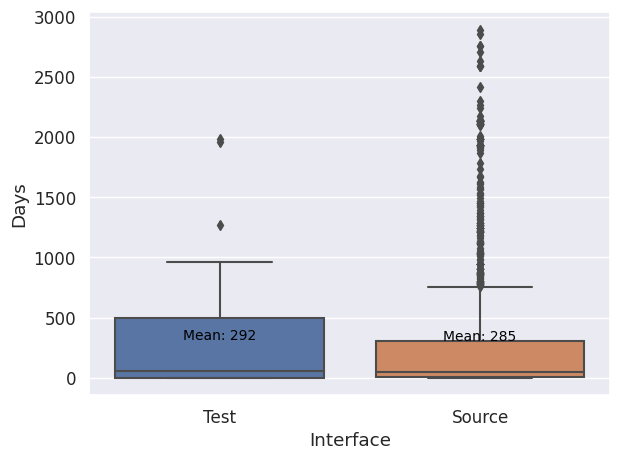

In [ ]:
g2 =  sns.boxplot(data=rq2_distribution_merging_impl, x="Type", y="Diff")
g2.set_ylabel("Days")
g2.set_xlabel("Interface")
medians = rq2_distribution_merging_impl.groupby('Type')['Diff'].mean()

# Add median annotations to the plot
plt.text(1, medians["Source"], f'Mean: {medians["Source"]:.0f}', ha='center', va='bottom', fontsize=10, color='black')
plt.text(0, medians["Test"], f'Mean: {medians["Test"]:.0f}', ha='center', va='bottom', fontsize=10, color='black')
plt.tight_layout()
plt.savefig("RQ2_Change_Day_Interface.pdf")

# RQ1-C [ COMLEXITY ]

In [19]:
PATH_COMPLEX = os.path.join("Dataset","result_inheritance")
REPO_PATH = 'repo'

In [78]:
test = pd.read_csv("beginning_test.csv")
source = pd.read_csv("beginning_source.csv")
test['ext'] = test['ext'].apply(ast.literal_eval)
test['impl']= test['impl'].apply(ast.literal_eval)
source['ext']= source['ext'].apply(ast.literal_eval)
source['impl']= source['impl'].apply(ast.literal_eval)

test['ext'] = test["ext"].apply(lambda x: [i for i in x if not i.lower() in ["testcase","assert","git parsed failed","git show failed"]])
source['ext'] = source["ext"].apply(lambda x: [i for i in x if not i.lower() in ["testcase","assert","git parsed failed","git show failed"]])

In [ ]:
result_test = []
result_source = []
for project,g in test.groupby("project"):
    data = json.load(open(os.path.join(PATH_RFT,project,project+"_refactoring_tree.json")))
    selected = test[test["project"] == project].reset_index()

    for index,t in enumerate(selected["file"]):
        temp = []
        for jndex in data[t]:
            row = data[t][jndex]
            commit = (row["commit"])
            lr = (row["left ==> right"])
            rft = (row["refactoring"])
            has_rft = (re.search(".* (extension|implementation)", rft.lower()))
            if has_rft:
                temp.append(commit+"::"+lr+"::"+has_rft.group(0))
        result_test.append([project,t,temp,len(selected["ext"].iloc[index])])

    selected = source[source["project"] == project].reset_index()
    for index,t in enumerate(selected["file"]):
        temp = []
        for jndex in data[t]:
            row = data[t][jndex]
            commit = (row["commit"])
            lr = (row["left ==> right"])
            rft = (row["refactoring"])
            has_rft = (re.search(".* (extension|implementation)", rft.lower()))
            if has_rft:
                temp.append(commit+"::"+lr+"::"+has_rft.group(0))
        result_source.append([project,t,temp,len(selected["ext"].iloc[index])])
df_test = pd.DataFrame(result_test,columns=["project","file","evolve","inheritance_created"])
df_source = pd.DataFrame(result_source,columns=["project","file","evolve","inheritance_created"])
df_test["evolve_len"] = df_test["evolve"].apply(len)
df_source["evolve_len"] = df_source["evolve"].apply(len)
df_test.to_csv("test_evolution.csv")


In [ ]:
def get_json(p):
    inheritance_deep = os.path.join(PATH_COMPLEX,p.lower()+"_inheritance_commitHistory_total.json")
    inheritance_deep = json.load(open(inheritance_deep,encoding='utf-8'))
    return inheritance_deep


In [54]:

def get_complexity(df,inheritance_deep,project):
    result = []
    for i in tqdm(range(0,df.shape[0])):
        evolve = (df["evolve"].iloc[i])
        file = (df["file"].iloc[i])
        for version in evolve:
            commit,lr,rft = version.split("::")
            if not rft in ["add class extension","add class implementation", \
                          "replace class extension","replace class implementation"] :
                continue
            lfile,rfile = lr.split(" ==> ")
            # found the one with right commits
            found_commits = [k for k in inheritance_deep if (commit in k)]
            found = [f for f in found_commits if (f.split("::")[-1].replace(".","/")+".java").lower() in rfile.lower()]
            if len(found) > 0:
                #'class vertex', 'superclass', 'class edge', 'subclass', 'modified class'
                superclass = (inheritance_deep[found[0]]["superclass"])
                result.append([project,file,rft,evolve,superclass])

    return pd.DataFrame(result,columns=["project","file","rft","evolve","supercass"])


100%|██████████| 12/12 [03:22<00:00, 16.91s/it]


In [79]:
res_source = []
res_test = []
for p in projects:
    g_test = df_test[df_test["project"] == p]
    g_source = df_source[df_source["project"] == p]
    inheritance_deep = get_json(p)

    res_test.append(get_complexity(g_test,inheritance_deep,p))
    res_source.append(get_complexity(g_source,inheritance_deep,p))


In [ ]:
df_complex_source = pd.concat(res_source)
df_complex_test= pd.concat(res_test)

df_complex_source = pd.concat(res_source)
df_complex_test= pd.concat(res_test)

df_complex_source.to_csv("source_complexity.csv")
df_complex_test.to_csv("test_complexity.csv")

df_complex_source["len_clean"] = (df_complex_source["supercass"].str[0:-1].apply(len))
df_complex_test["len_clean"] = (df_complex_test["supercass"].str[0:-1].apply(len))

y_add_test_ext = df_complex_test[df_complex_test["rft"] == "add class extension"]["len_clean"].tolist()
y_replace_test_ext = df_complex_test[df_complex_test["rft"] == "replace class extension"]["len_clean"].tolist()
y_add_src_ext = df_complex_source[df_complex_source["rft"] == "add class extension"]["len_clean"].tolist()
y_replace_src_ext = df_complex_source[df_complex_source["rft"] == "replace class extension"]["len_clean"].tolist()

y_add_test_impl = df_complex_test[df_complex_test["rft"] == "add class implementation"]["len_clean"].tolist()
y_replace_test_impl = df_complex_test[df_complex_test["rft"] == "replace class implementation"]["len_clean"].tolist()
y_add_src_impl = df_complex_source[df_complex_source["rft"] == "add class implementation"]["len_clean"].tolist()
y_replace_src_impl = df_complex_source[df_complex_source["rft"] == "replace class implementation"]["len_clean"].tolist()

import plotly.express as px

fig = make_subplots(rows=1, cols=4,
                    y_title="Depth of <br> Inheritance Tree"
                    )

fig.add_trace(go.Box(y=y_add_test_ext,
                     marker_color='#1338BE',
                    name='Test File'),row=1,col=1)


fig.add_trace(go.Box(y=y_add_src_ext,
                     marker_color='#F75D59',
                    name='Source File'),row=1,col=1)


fig.add_trace(go.Box(y=y_replace_test_ext,
                    marker_color='#1338BE',
                    name='Test File'),row=1,col=2)

fig.add_trace(go.Box(y=y_replace_src_ext,
                    marker_color='#F75D59',
                    name='Source File'),row=1,col=2)


fig.add_trace(go.Box(y=y_add_test_impl,
                     marker_color='#1338BE',
                    name='Test File'),row=1,col=3)


fig.add_trace(go.Box(y=y_add_src_impl,
                     marker_color='#F75D59',
                    name='Source File'),row=1,col=3)


fig.add_trace(go.Box(y=y_replace_test_impl,
                    marker_color='#1338BE',
                    name='Test File'),row=1,col=4)

fig.add_trace(go.Box(y=y_replace_src_impl,
                    marker_color='#F75D59',
                    name='Source File'),row=1,col=4)

fig.update_xaxes(title_font_family="Arial",title="Add Class <br> Ext.",row=1,col=1)
fig.update_xaxes(title_font_family="Arial",title="Replace Class <br> Ext.",row=1,col=2)
fig.update_xaxes(title_font_family="Arial",title="Add Class <br> Impl.",row=1,col=3)
fig.update_xaxes(title_font_family="Arial",title="Replace Class <br> Impl.",row=1,col=4)

fig.update_layout(
     height=300, width=1000,
     margin=go.layout.Margin(
        t=10,  #top margin,
        b=0
    ),
    showlegend=False
)
fig.update_xaxes(title_font_family="Arial",title="Code Type")
fig.update_yaxes(title_font_family="Arial",title="No. of Days <br> Between Inheritance Changes")

